In [1]:
!pip install indoNLP emoji nlpaug Sastrawi bertopic sentence-transformers minisom hdbscan

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=324d0eececc9c91cb05779cefd9d4116950567ca50e09e1bab7838f6fc7bfccd
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import nltk
import shutil
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tqdm.auto as tqdm
import spacy
import json
import logging
import os
import sys
import multiprocessing
import torch
import string

from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
from indoNLP.preprocessing import emoji_to_words, replace_slang, pipeline
from __future__ import print_function
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.word.context_word_embs as aug
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from textblob import TextBlob
from nltk import ngrams

warnings.filterwarnings("ignore")

# **ETL**

In [3]:
!unzip /content/data.zip -d /content/data

Archive:  /content/data.zip
   creating: /content/data/tweets-data/
  inflating: /content/data/tweets-data/kurikulum-merdeka-persen-part2.csv  
  inflating: /content/data/tweets-data/#kurikulum-merdeka-persen.csv  
  inflating: /content/data/tweets-data/kurikulum-merdeka-persen.csv  


In [4]:
list_data = os.listdir('/content/data/tweets-data')

In [5]:
data = [pd.read_csv(os.path.join("/content/data/tweets-data", data)) for data in list_data if data.endswith(".csv")]
df = pd.concat(data)

In [6]:
df['opened_at'] = dt.datetime.now()

# **Pembersihan Data**

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
import re
import emoji

def data_cleaning_pipeline(text: str):
    if not isinstance(text, str):
        text = str(text)

    def remove_emojis(input_text):
        return emoji.replace_emoji(input_text, replace='')  # Menghapus emoji dengan menggantinya menjadi string kosong

    step_1 = remove_emojis(text)  # Hapus emoji
    step_2 = replace_slang(step_1)  # Ubah slang menjadi kata formal
    step_3 = re.sub(r'http\S+', '', step_2)  # Hapus URL
    step_4 = re.sub(r'\B[@#]\w+\b', '', step_3)  # Hapus hashtag dan mention
    step_5 = re.sub(r'[^\w\s]', ' ', step_4)  # Hapus karakter non-alfanumerik kecuali spasi
    step_6 = re.sub(r'\d+', '', step_5)  # Hapus angka
    step_7 = re.sub(r'\s+', ' ', step_6)  # Hapus spasi berlebih

    # Menghilangkan kata yang duplikat
    words = step_7.split()
    step_8 = ' '.join(sorted(set(words), key=words.index))  # Menghilangkan duplikat dan mempertahankan urutan asli

    return step_8.strip().lower()

In [9]:
df['full_text'] = df['full_text'].apply(data_cleaning_pipeline)
df.dropna(subset=["full_text"], inplace=True)
df.drop_duplicates(subset=['full_text'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df['full_text']

,full_text
0,hasil kreasi kurikulum merdeka
1,nah ini kok enggak viral sih efek kurikulum me...
2,kurikulum merdeka ya keren banget pembelajaran...
3,wah keren banget model pembelajarannya guru kr...
4,allah bersama siswa kurikulum merdeka
...,...
4733,tahukan kamu melalui penguatan profil pelajar ...
4734,pembelajaran biologi kali ini masih tetap mema...
4735,apa kata kepala sekolah smpn jabon tentang kur...
4736,yuk saksikan selengkapnya di youtube bskap kem...


In [ ]:
# for data in df['full_teks_clean']:
#     if not isinstance(data, str):
#         print(data)

In [ ]:
# df_kamus_alay = pd.read_csv('/content/kamusalay.csv', names=['alay', 'formal'], encoding='latin-1')
# df_kamus_kamus = pd.read_csv('/content/colloquial-indonesian-lexicon.csv').iloc[:, :2]
# df_new_alay = pd.read_csv('/content/new_kamusalay.csv', encoding="latin-1")
# df_kamus_kamus.columns = ['alay', 'formal']
# df_new_alay.columns = ['alay', 'formal']

In [ ]:
# with open("/content/daftar_baku_lantip.json", "r") as file:
#     data_lantip = json.load(file)

In [ ]:
# with open("/content/daftar_baku_ivanlanin.json", "r") as file:
#     data_ivan = json.load(file)

In [ ]:
# df_lantip = pd.DataFrame(list(data_lantip.items()), columns=['alay', 'formal'])
# df_ivan = pd.DataFrame(list(data_ivan.items()), columns=['alay', 'formal'])

In [ ]:
# df_full_kamus = pd.concat([df_kamus_alay, df_kamus_kamus, df_lantip, df_ivan])
# df_full_kamus.drop_duplicates(subset=['alay'], inplace=True)

In [11]:
df_full_kamus = pd.read_csv('/content/kamus_lengkap.csv')

In [12]:
list_teks = [teks for teks in df['full_text'].tolist()]
full_teks = '|'.join(list_teks)

In [ ]:
for index, row in df_full_kamus.iterrows():
    alay = row['alay']
    formal = row['formal']
    full_teks = re.sub(rf'\b{alay}\b(?=\W|$)', formal, full_teks)

In [13]:
df['full_text_formal'] = full_teks.split("|")

# **Pembersihan Lanjutan**

In [14]:
list_teks = [teks for teks in df['full_text_formal'].tolist()]
full_teks_stop = '|'.join(list_teks)

In [15]:
stop_1 = pd.read_csv('/content/stopwordbahasa.csv')
stop_2 = pd.read_csv('/content/stopwords_twitter.csv')
stop_1.columns = ['stopword']
stop_2.columns = ['stopword']
full_stop = pd.concat([stop_1, stop_2])

In [16]:
full_stop.reset_index(drop=True, inplace=True)

In [17]:
for index, row in full_stop.iterrows():
    alay = row['stopword']
    formal = ""
    full_teks_stop = re.sub(rf'\b{alay}\b(?=\W|$)', formal, full_teks_stop)

In [18]:
df['full_text_formal_stop'] = full_teks_stop.split("|")

# **Stem**

In [19]:
!pip install stanza

import stanza

stanza.download("id")
nlp = stanza.Pipeline("id")

def lemmastanZa(teks):
  doc = nlp(teks)
  hasil = " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])
  return hasil

df['full_text_formal_stop_stanza'] = df['full_text_formal_stop'].apply(lemmastanZa)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.0 MB/s eta 0:00:00


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: id (Indonesian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/id/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor    | Package      |
-------------------------------
| tokenize     | gsd          |
| mwt          | gsd          |
| pos          | gsd_charlm   |
| lemma        | gsd_nocharlm |
| constituency | icon_charlm  |
| depparse     | gsd_charlm   |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [24]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def textStem(teks):
  hasil = stemmer.stem(teks)
  return hasil

df['full_text_formal_stop_stem'] = df['full_text_formal_stop'].apply(textStem)

In [25]:
df[['full_text_formal_stop_stanza', 'full_text_formal_stop_stem']]

,full_text_formal_stop_stanza,full_text_formal_stop_stem
0,hasil kreasi kurikulum merdeka,hasil kreasi kurikulum merdeka
1,viral efek kurikulum merdeka guru anak kreatif...,viral efek kurikulum merdeka guru anak kreatif...
2,kurikulum merdeka keren belajar anak aktif kre...,kurikulum merdeka keren ajar anak aktif kreati...
3,keren model belajar dia guru kreatif murid bel...,keren model ajar guru kreatif murid ajar aktif...
4,allah siswa kurikulum merdeka,allah siswa kurikulum merdeka
...,...,...
4733,tahu kuat profil pelajar pancasila p manfaat m...,tahu kuat profil ajar pancasila p manfaat muri...
4734,belajar biologi kali manfaat educaplay game as...,ajar biologi kali manfaat educaplay game asses...
4735,kepala sekolah smpn jabon kurikulum merdeka si...,kepala sekolah smpn jabon kurikulum merdeka si...
4736,saksi selengkap nya youtube bskap kemendikbudr...,saksi lengkap youtube bskap kemendikbudristek ...


In [26]:
df.to_csv('data.csv', index=False)

# **EDA**

In [27]:
data = df.copy(deep=True)

In [28]:
print(f"Jumlah baris: {data.shape[0]}, Jumlah kolom: {data.shape[1]}")
print(data.info())

print(data.isnull().sum())

Jumlah baris: 4738, Jumlah kolom: 20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4738 entries, 0 to 4737
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   conversation_id_str           4738 non-null   int64         
 1   created_at                    4738 non-null   object        
 2   favorite_count                4738 non-null   int64         
 3   full_text                     4738 non-null   object        
 4   id_str                        4738 non-null   int64         
 5   image_url                     511 non-null    object        
 6   in_reply_to_screen_name       2731 non-null   object        
 7   lang                          4738 non-null   object        
 8   location                      2464 non-null   object        
 9   quote_count                   4738 non-null   int64         
 10  reply_count                   4738 non-null   int64        

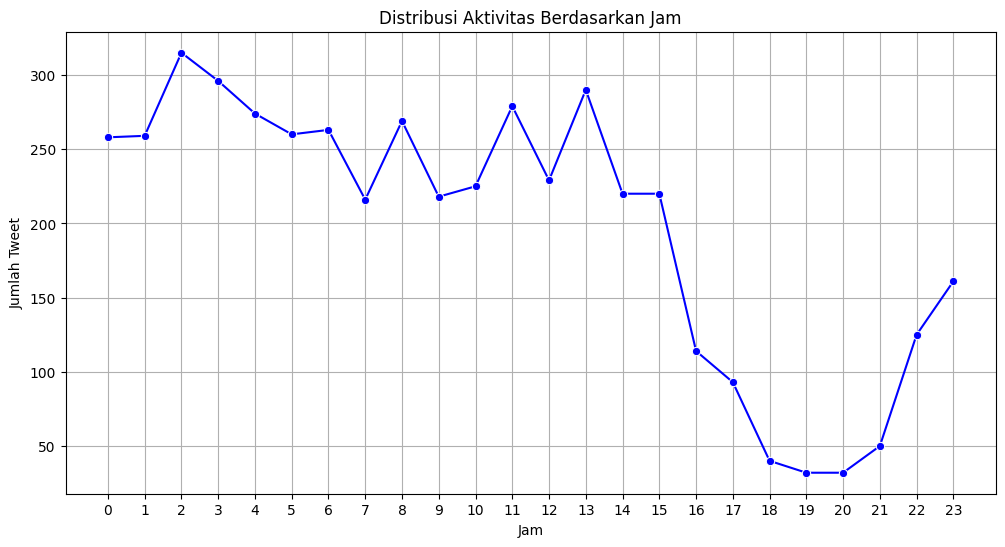

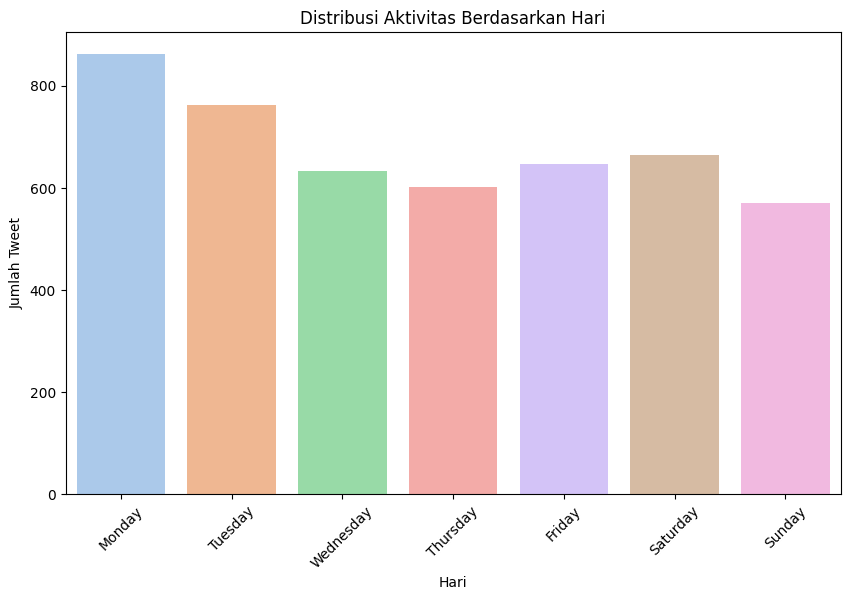

In [29]:
# 1. Distribusi waktu (jam dan hari)
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')
data['hour'] = data['created_at'].dt.hour
data['day_of_week'] = data['created_at'].dt.day_name()

# Aktivitas berdasarkan jam
hourly_activity = data['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_activity.index, y=hourly_activity.values, marker='o', color='blue')
plt.title("Distribusi Aktivitas Berdasarkan Jam")
plt.xlabel("Jam")
plt.ylabel("Jumlah Tweet")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Aktivitas berdasarkan hari
daily_activity = data['day_of_week'].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(10, 6))
sns.barplot(x=daily_activity.index, y=daily_activity.values, palette="pastel")
plt.title("Distribusi Aktivitas Berdasarkan Hari")
plt.xlabel("Hari")
plt.ylabel("Jumlah Tweet")
plt.xticks(rotation=45)
plt.show()

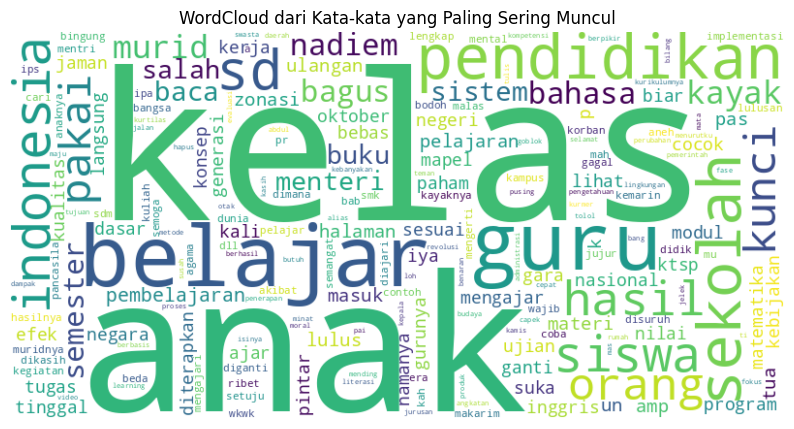

In [38]:
text_data = ' '.join(data['full_text_formal_stop'].dropna().astype(str))

words = [word for word in text_data.split() if word.lower() not in stop_words and word.lower() not in ['merdeka', 'kurikulum']]


word_freq = Counter(words)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud dari Kata-kata yang Paling Sering Muncul")
plt.show()

In [39]:
def generate_ngrams(text, n):
    tokens = text.split()
    return list(ngrams(tokens, n))

text_data = ' '.join(data['full_text_formal_stop'].dropna().astype(str))

stop_words = set(stopwords.words('indonesian') + list(string.punctuation))
tokens = [word for word in text_data.split() if word.lower() not in stop_words and word.lower() not in ['merdeka', 'kurikulum']]

bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

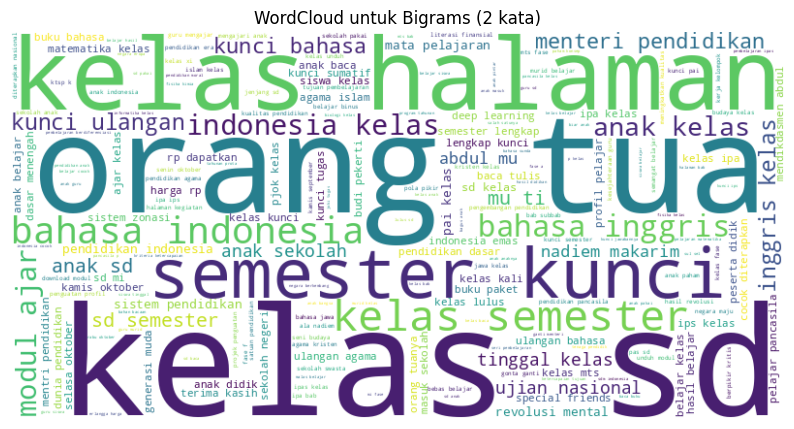

In [40]:
bigram_wordcloud_data = {" ".join(k): v for k, v in bigram_freq.items()}

bigram_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(bigram_wordcloud_data)

plt.figure(figsize=(10, 6))
plt.imshow(bigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud untuk Bigrams (2 kata)")
plt.show()

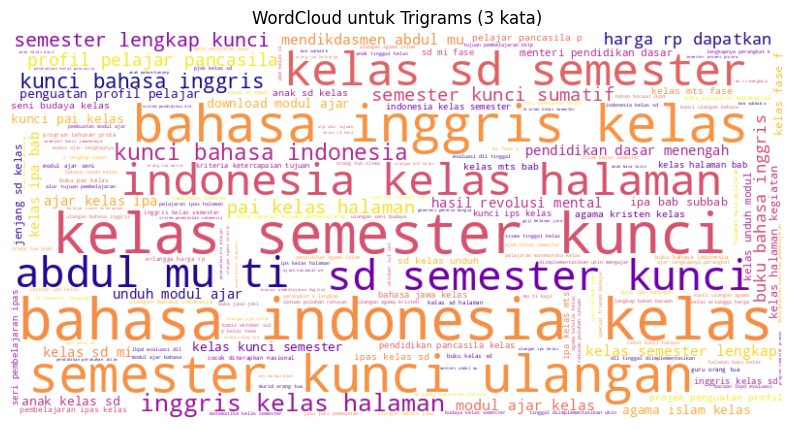

In [41]:
trigram_wordcloud_data = {" ".join(k): v for k, v in trigram_freq.items()}

trigram_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate_from_frequencies(trigram_wordcloud_data)

plt.figure(figsize=(10, 6))
plt.imshow(trigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud untuk Trigrams (3 kata)")
plt.show()

<Figure size 1000x600 with 0 Axes>

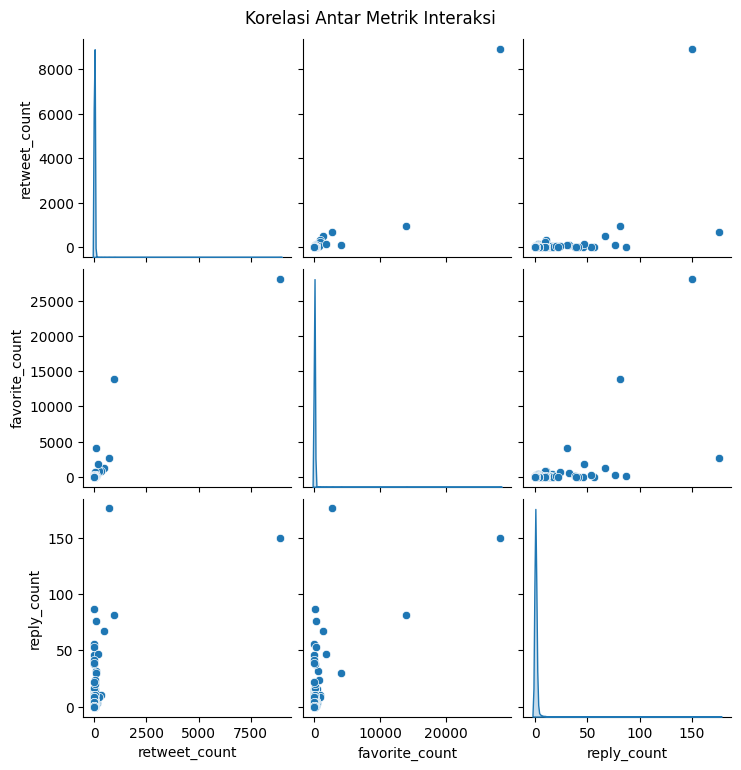

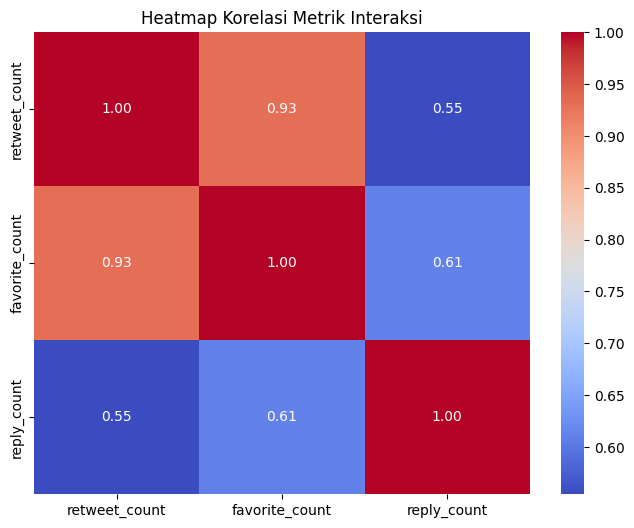

In [42]:
plt.figure(figsize=(10, 6))
sns.pairplot(data, vars=['retweet_count', 'favorite_count', 'reply_count'], diag_kind="kde")
plt.suptitle("Korelasi Antar Metrik Interaksi", y=1.02)
plt.show()

correlation = data[['retweet_count', 'favorite_count', 'reply_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi Metrik Interaksi")
plt.show()

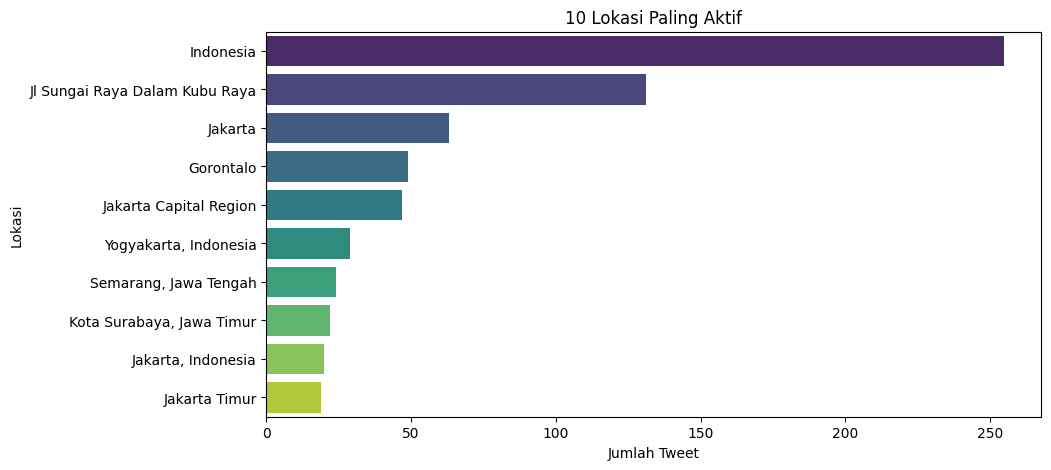

In [43]:
top_locations = data['location'].dropna().value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("10 Lokasi Paling Aktif")
plt.xlabel("Jumlah Tweet")
plt.ylabel("Lokasi")
plt.show()

In [44]:
!pip install transformers torch

import pandas as pd
import torch  # Import library to manage tensor types
from transformers import pipeline

# Load the pre-trained model and tokenizer
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

# Ensure all text inputs are strings and handle empty cases
def analyze_sentiment(text):
    if pd.isnull(text) or not isinstance(text, str):  # Validate text input
        return {"label": "neutral", "score": 0.0}
    try:
        result = nlp(text)[0]  # Sentiment analysis on the text
    except Exception as e:
        print(f"Error processing text: {text}, Error: {e}")
        return {"label": "neutral", "score": 0.0}
    return result

# Assuming 'data' is a DataFrame with a 'full_text' column
data['full_text'] = data['full_text'].astype(str)  # Ensure all entries are strings
data['sentiment_result'] = data['full_text'].apply(analyze_sentiment)

# Extract the label and score
data['sentiment'] = data['sentiment_result'].apply(lambda x: x['label'])
data['sentiment_score'] = data['sentiment_result'].apply(lambda x: x['score'])

# Print results for verification
print(data[['full_text', 'sentiment', 'sentiment_score']].head())


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                           full_text sentiment  \
0                     hasil kreasi kurikulum merdeka   neutral   
1  nah ini kok enggak viral sih efek kurikulum me...  positive   
2  kurikulum merdeka ya keren banget pembelajaran...  positive   
3  wah keren banget model pembelajarannya guru kr...  positive   
4              allah bersama siswa kurikulum merdeka   neutral   

   sentiment_score  
0         0.997385  
1         0.987165  
2         0.998683  
3         0.994995  
4         0.998128  


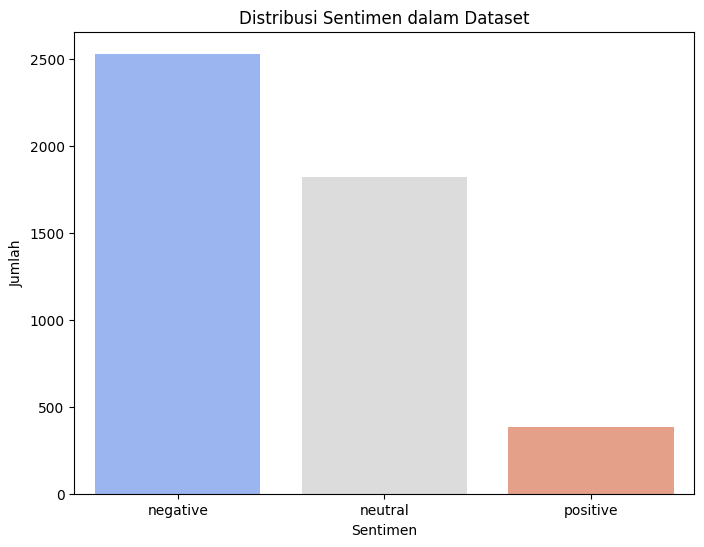

In [45]:
sentiment_counts = data['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribusi Sentimen dalam Dataset")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

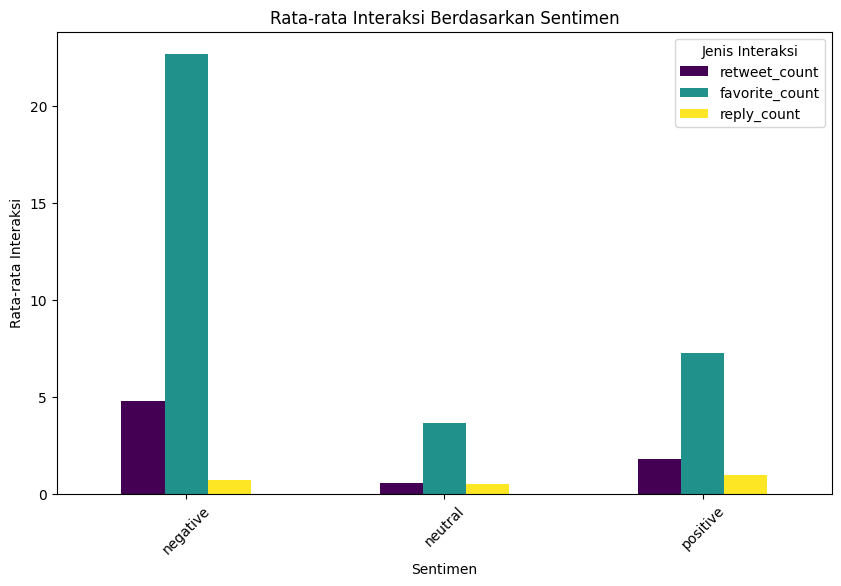

In [46]:
interaction_by_sentiment = data.groupby('sentiment')[['retweet_count', 'favorite_count', 'reply_count']].mean()

interaction_by_sentiment.plot(kind='bar', figsize=(10, 6), colormap="viridis")
plt.title("Rata-rata Interaksi Berdasarkan Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Rata-rata Interaksi")
plt.xticks(rotation=45)
plt.legend(title="Jenis Interaksi")
plt.show()

# **Analisis Sentiment**

In [ ]:
df = pd.read_csv('/content/sentiment_analysis_results.csv')

In [ ]:
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
model_2 = AutoModelForSequenceClassification.from_pretrained(pretrained_name)
tokenizer_2 = AutoTokenizer.from_pretrained(pretrained_name)

nlp = pipeline("sentiment-analysis", model=model_2, tokenizer=tokenizer_2)

def predict_sentiment(text):
    text = str(text).strip()

    if not text:
        return 'UNKNOWN'

    inputs = tokenizer_2(text, return_tensors="pt")

    inputs = {key: value.to(torch.long) for key, value in inputs.items()}

    with torch.no_grad():
        result = model_2(**inputs)

    logits = result.logits
    predicted_class_idx = torch.argmax(logits, dim=-1).item()
    label_map = {0: 'NEGATIVE', 1: 'POSITIVE'}
    predicted_label = label_map.get(predicted_class_idx, 'UNKNOWN')

    return predicted_label

df['sentiment'] = df['full_text'].apply(predict_sentiment)

# **Named Entity Recognition**

In [ ]:
ner_pipeline = pipeline("ner", model="cahya/bert-base-indonesian-NER", aggregation_strategy="simple")

# Define the function to extract entities
def get_entities(text):
    if type(text) != float:
        ner_results = ner_pipeline(text)
        entities = [{"entity": ent["word"], "label": ent["entity_group"], "score": ent["score"]} for ent in ner_results]
        return entities
    else:
        return []

# Apply the function to extract entities for each text entry in 'full_text' column
df["entities"] = df["full_text"].apply(get_entities)

Some weights of the model checkpoint at cahya/bert-base-indonesian-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# **Topic Modeling**

In [69]:
df[['sentiment_result',	'sentiment',	'sentiment_score']] = data[['sentiment_result',	'sentiment',	'sentiment_score']]

In [70]:
documents = df[['full_text_formal_stop_stanza', 'sentiment']]

In [83]:
documents['full_text_formal_stop_stanza'] = documents['full_text_formal_stop_stanza'].str.replace(r'\b(kurikulum|merdeka)\b', '', regex=True)

In [89]:
import nltk
from nltk.corpus import stopwords
import pandas as pd

# Pastikan stopwords telah diunduh
nltk.download('stopwords')

# Mendapatkan stopwords dalam bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghapus stopwords dari teks
def remove_stopwords(text):
    # Memisahkan teks menjadi kata-kata
    words = text.split()
    # Menghilangkan stopwords dari kata-kata yang ada
    filtered_words = [word for word in words if word not in stop_words]
    # Menggabungkan kembali kata-kata yang tersisa
    return ' '.join(filtered_words)

# Menghilangkan stopwords dari kolom 'full_text_formal_stop_stanza'
documents['full_text_formal_stop_stanza'] = documents['full_text_formal_stop_stanza'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.to_csv('curriculumecho.csv', index=False)

### **Dimension Reduction**

In [71]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import tensorflow as tf

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

pca_model = PCA(n_components=5)

tsne_model = TSNE(n_components=2, random_state=42)

lle_model = LocallyLinearEmbedding(n_components=2)


class Autoencoder(tf.keras.Model):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            tf.keras.layers.Dense(encoding_dim, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(encoding_dim,)),
            tf.keras.layers.Dense(input_dim, activation="sigmoid")
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

input_dim = 300
encoding_dim = 10
autoencoder = Autoencoder(encoding_dim)
autoencoder.compile(optimizer="adam", loss="mse")

reduced_model = autoencoder.encoder

### **Clustering**

In [186]:
import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from minisom import MiniSom

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean', prediction_data=True)

kmeans_model = KMeans(n_clusters=15, random_state=42)

agglomerative_model = AgglomerativeClustering(n_clusters=20)

### **Embedding**

In [166]:
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer

sbert_model = SentenceTransformer("all-mpnet-base-v2")
embeddings_sbert_model = sbert_model.encode(documents['full_text_formal_stop_stanza'], show_progress_bar=True)

Batches:   0%|          | 0/149 [00:00<?, ?it/s]

## **Model Positive**

In [211]:
pos_doc = documents[documents['sentiment'] == 'positive']
topic_model_positive = BERTopic(umap_model=umap_model, calculate_probabilities=True, embedding_model=sbert_model, hdbscan_model=kmeans_model)

topics, probabilities = topic_model_positive.fit_transform(pos_doc['full_text_formal_stop_stanza'])

In [212]:
topic_model_positive.get_topic(0)

[('guru', 0.10951775859524827),
 ('anak', 0.045214074041587074),
 ('belajar', 0.04042064328983293),
 ('didik', 0.03453594921651541),
 ('motivasi', 0.031842552848264254),
 ('ajar', 0.029885855741025008),
 ('orang', 0.0285258986938293),
 ('terap', 0.027201739944891012),
 ('modul', 0.026893004427433885),
 ('bingung', 0.025474042278611404)]

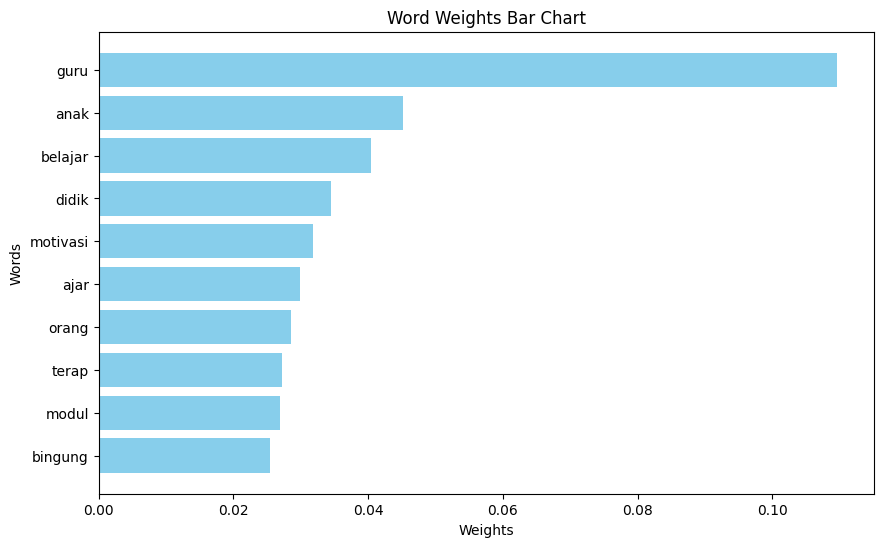

In [229]:
words = []
values = []
for word, value in topic_model_positive.get_topic(0):
  words.append(word)
  values.append(value)


# Plotting
plt.figure(figsize=(10, 6))
plt.barh(words, values, color='skyblue')
plt.xlabel('Weights')
plt.ylabel('Words')
plt.title('Word Weights Bar Chart')
plt.gca().invert_yaxis()  # Reverse the order to have the highest value at the top
plt.show()

In [213]:
topic_model_positive.visualize_barchart(top_n_topics=12)

## **Model Negative**

In [214]:
neg_doc = documents[documents['sentiment'] == 'negative']

topic_model_Negative = BERTopic(umap_model=umap_model, calculate_probabilities=True, embedding_model=sbert_model, hdbscan_model=
agglomerative_model)

topics_neg, probabilities_neg = topic_model_Negative.fit_transform(neg_doc['full_text_formal_stop_stanza'])

In [215]:
topic_model_Negative.get_topic(0)

[('bodoh', 0.05585629176438397),
 ('hasil', 0.04646357788678995),
 ('salah', 0.04523091562067924),
 ('pagai', 0.0390865051407139),
 ('anak', 0.03811356779300763),
 ('nadiem', 0.03753650432764086),
 ('sekolah', 0.030370710691124767),
 ('bangsa', 0.030131203376315523),
 ('coba', 0.02995883574783294),
 ('belajar', 0.027751093842333447)]

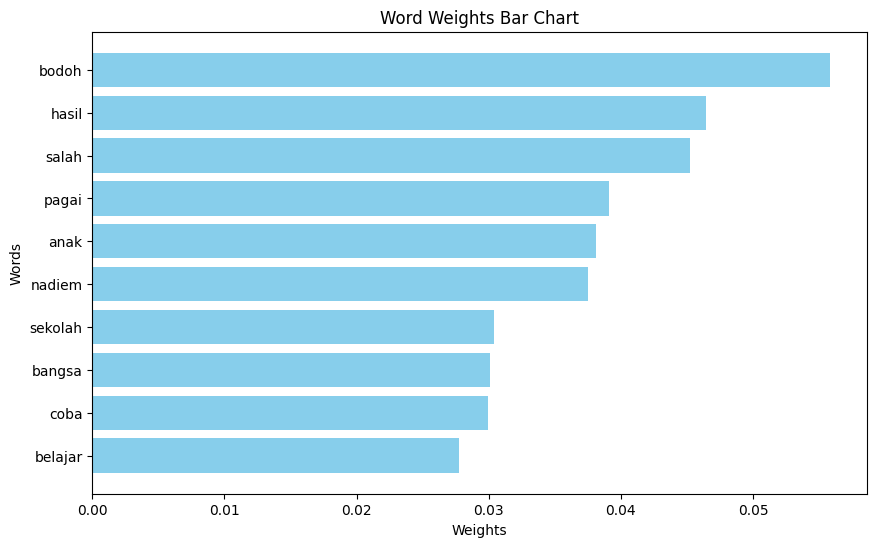

In [228]:
words = []
values = []
for word, value in topic_model_Negative.get_topic(0):
  words.append(word)
  values.append(value)


# Plotting
plt.figure(figsize=(10, 6))
plt.barh(words, values, color='skyblue')
plt.xlabel('Weights')
plt.ylabel('Words')
plt.title('Word Weights Bar Chart')
plt.gca().invert_yaxis()  # Reverse the order to have the highest value at the top
plt.show()

In [216]:
topic_model_Negative.visualize_barchart(top_n_topics=12)

## **Model Netral**

In [222]:
net_doc = documents[documents['sentiment'] == 'neutral']

topic_model_Netral = BERTopic(umap_model=umap_model, calculate_probabilities=True, embedding_model=sbert_model, hdbscan_model=
agglomerative_model)

topics_net, probabilities_net = topic_model_Netral.fit_transform(net_doc['full_text_formal_stop_stanza'])

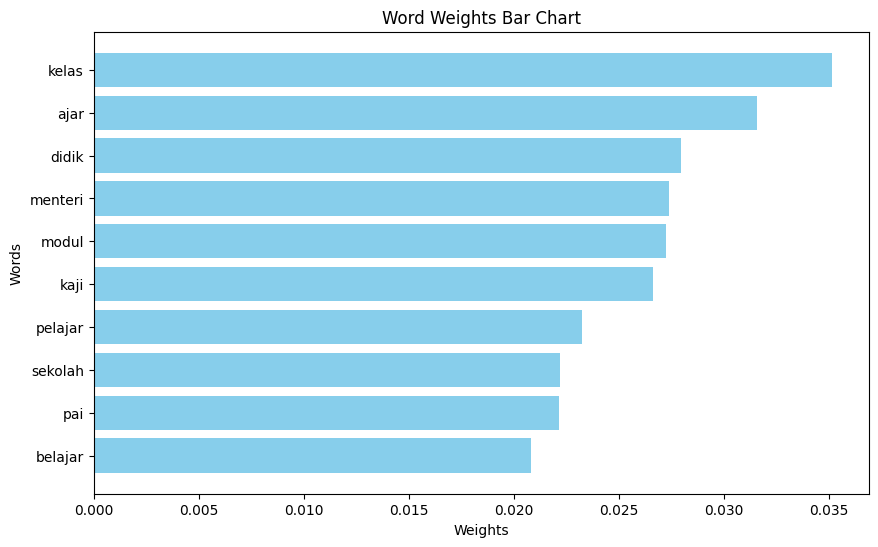

In [227]:

words = []
values = []
for word, value in topic_model_Netral.get_topic(0):
  words.append(word)
  values.append(value)


# Plotting
plt.figure(figsize=(10, 6))
plt.barh(words, values, color='skyblue')
plt.xlabel('Weights')
plt.ylabel('Words')
plt.title('Word Weights Bar Chart')
plt.gca().invert_yaxis()  # Reverse the order to have the highest value at the top
plt.show()

In [ ]:
topic_model_positive

In [195]:
topic_model_Netral.visualize_barchart(top_n_topics=10)

# **Metrik Evaluasi**

In [217]:
from sklearn.metrics import silhouette_score

neg_doc = neg_doc.reset_index(drop=True)

embed_neg = sbert_model.encode(neg_doc['full_text_formal_stop_stanza'].tolist(), show_progress_bar=False)


umap_embeddings_neg = topic_model_Negative.umap_model.transform(embed_neg)
indices_neg = [index for index, topic in enumerate(topics) if topic != -1]
X_neg = umap_embeddings_neg[np.array(indices_neg)]
labels_neg = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
neg = silhouette_score(X_neg, labels_neg)

In [218]:
pos_doc = pos_doc.reset_index(drop=True)

embed_pos = sbert_model.encode(pos_doc['full_text_formal_stop_stanza'].tolist(), show_progress_bar=False)


umap_embeddings_pos = topic_model_Netral.umap_model.transform(embed_pos)
indices_pos = [index for index, topic in enumerate(topics) if topic != -1]
X_pos = umap_embeddings_pos[np.array(indices_pos)]
labels_pos = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
pos = silhouette_score(X_pos, labels_pos)

In [219]:
net_doc = net_doc.reset_index(drop=True)

embed_net = sbert_model.encode(net_doc['full_text_formal_stop_stanza'].tolist(), show_progress_bar=False)


umap_embeddings_net = topic_model_Netral.umap_model.transform(embed_net)
indices_net = [index for index, topic in enumerate(topics) if topic != -1]
X_net = umap_embeddings_net[np.array(indices_net)]
labels_net = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
net = silhouette_score(X_net, labels_net)

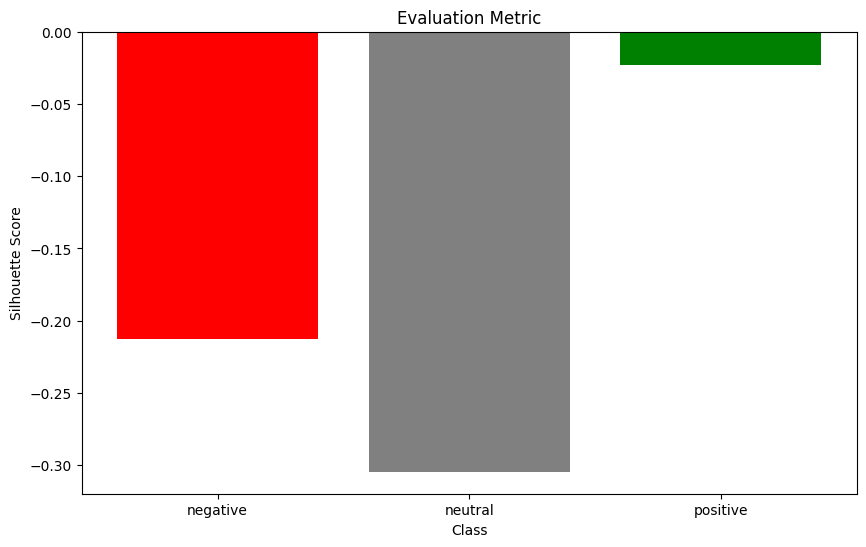

In [221]:
x = ['negative', 'neutral', 'positive']
y = [neg, net, pos]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x, y, color=['red', 'gray', 'green'])
plt.xlabel('Class')
plt.ylabel('Silhouette Score')
plt.title('Evaluation Metric')
plt.show()